In [65]:
import random, time
import numpy as np
import seaborn as sns;
import matplotlib.pyplot as plt
import heapq
from os import getcwd, path


random.seed(10301949)
np.random.seed(10301949)

# basic LSH mode
# HASH_LENGTH = 16
# NUM_KENYON = 16
# WTA = "all"
# SPARSE = False
# SAMPLES = 0

# fly mode
HASH_LENGTH = 16
NUM_KENYON = 1280
WTA = "top"
SPARSE = True
SAMPLES = 12

N   = 100
DIM = 784
D   = None

NUM_REPEATS = 10
NUM_NNS = max(10,int(0.02*N))        
DIST_FN = "norm2"


def plot(matrix2d):
    dims = (12, 2)
    fig, ax = plt.subplots(figsize=dims, dpi=200)
    p = sns.heatmap(matrix2d, ax=ax, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.show()

    
def read_generic_data(filename):
    """ Generic reader for: sift, gist, corel, mnist, glove, audio, msong. """
    filepath = path.abspath(path.join(getcwd(), filename))
    
    D = np.zeros((N,DIM))
    with open(filepath, "r") as f:
        for line_num,line in enumerate(f):
            
            cols = line.strip().split(",")
            assert len(cols) == DIM
            
            D[line_num,:] = [float(s) for s in cols]
            #D[line_num,:] = map(float,cols)
            #D[line_num,:] *= -1 # to invert distribution?
            
    assert line_num+1 == N
    
    return D


def standardize_data(D):
    """ Performs several standardizations on the data.
            1) Makes sure all values are non-negative.
            2) Sets the mean of example to SET_MEAN.
            3) Applies normalization if desired.
    """
    
    # 1. Add the most negative number per column (ORN) to make all values >= 0.
    for col in range(DIM):
        #print(abs(min(D[:,col])))
        D[:,col] += abs(min(D[:,col]))
        
    # 2. Set the mean of each row (odor) to be SET_MEAN.
    for row in range(N):
        # Multiply by: SET_MEAN / current mean. Keeps proportions the same.
        D[row,:] = D[row,:] * ((100 / np.mean(D[row,:])))
        D[row,:] = [int(s) for s in D[row,:]]
        #D[row,:] = map(int,D[row,:])        
        
        assert abs(np.mean(D[row,:]) - 100) <= 1

    return D


def create_rand_proj_matrix(sparseBinary=False, samples=6):
    """ Creates a random projection matrix of size NUM_KENYON by NUM_ORNS. """

    # Create a sparse, binary random projection matrix.
    if sparseBinary:

        assert samples <= DIM

        # Each row (KC) samples from the glomeruli: every row has num_sample
        # random 1s, and 0s everywhere else.
        M = np.zeros((NUM_KENYON,DIM))
        for row in range(NUM_KENYON):

            # Sample NUM_SAMPLE random indices, set these to 1.
            for idx in random.sample(range(DIM),samples):
                M[row,idx] = 1

            # Make sure I didn't screw anything up!
            assert sum(M[row,:]) == samples       

    # Create a dense, Gaussian random projection matrix.
    else:
        M = np.random.randn(NUM_KENYON, DIM)

    return M


def winnerTakeAll():
    # Apply WTA to KCs: firing rates at indices corresponding to top/bot/rand/all KCs; 0s elsewhere.
    if WTA == "random":# fix indices for all odors, otherwise, can't compare.
        rand_indices = random.sample(range(NUM_KENYON),HASH_LENGTH)

    
    H = np.zeros((N, NUM_KENYON))
    for i in range(N):
        # Take all neurons.
        if WTA == "all":
            assert HASH_LENGTH == NUM_KENYON
            indices = range(NUM_KENYON)

        # Highest firing neurons.
        elif WTA == "top":      
            indices = np.argpartition(K[i,:],-HASH_LENGTH)[-HASH_LENGTH:] 

        # Lowest firing neurons.
        elif WTA == "bottom": 
            indices = np.argpartition(K[i,:],HASH_LENGTH)[:HASH_LENGTH]
            plot([indices])
            
        # Random neurons. 
        elif WTA == "random": 
            indices = rand_indices#random.sample(xxrange(NUM_KENYON),HASH_LENGTH)

        else: assert False
            
        H[i,:][indices] = K[i,:][indices]
        
    return H

def main():
    x_map = [None] * NUM_REPEATS
    for ii in range(NUM_REPEATS):
        M = create_rand_proj_matrix(SPARSE, SAMPLES)
        K = np.dot(D,np.transpose(M)) 
        offset,width = 0,10
        K = np.floor((K+offset)/width)
        H = winnerTakeAll()
        x_map[ii] = test_map_dist(D,H)

    return [np.mean(x_map), np.std(x_map)]

def test_map_dist(D,H):
    """ Computes mean average precision (MAP) and distortion between true nearest-neighbors  
        in input space and approximate nearest-neighbors in hash space. 
    """    
    queries = random.sample(range(N),100)

    MAP = [] # [list of MAP values for each query]      
    for i in queries: 
        temp_i = [] # list of (dist input space,odor) from i.
        temp_h = [] # list of (dist hash space ,odor) from i.
        for j in range(N):
            if i == j: continue

            # Distance between i and j in input space.
            dij_orig = dist(D[i,:],D[j,:])
            if dij_orig <= 0: continue # i and j are duplicates, e.g. corel: i=1022,j=2435.
            temp_i.append( (dij_orig,j) )
                            
            # Distance between i and j in hash space.
            dij_hash = dist(H[i,:],H[j,:])
            temp_h.append( (dij_hash,j) )
                            
        assert len(temp_i) == len(temp_h) # == N-1 # not the last part bc of duplicates.

        # Create a set of the true NUM_NNS nearest neighbors.
        # true_nns = sorted(temp_i)[0:NUM_NNS]      # true NUM_NNS tuples.
        true_nns = heapq.nsmallest(NUM_NNS,temp_i) # true NUM_NNS tuples. (faster than above)
        true_nns = set([vals[1] for vals in true_nns]) # true NUM_NNS examples.

        # Go through predicted nearest neighbors and compute the MAP.
        # pred_nns = sorted(temp_h)[0:NUM_NNS]      # pred NUM_NNS tuples.
        pred_nns = heapq.nsmallest(NUM_NNS,temp_h) # pred NUM_NNS tuples. (faster than above)
        pred_nns = [vals[1] for vals in pred_nns] # pred NUM_NNS examples.

        assert len(true_nns) == len(pred_nns)

        # Compute MAP: https://makarandtapaswi.wordpress.com/2012/07/02/intuition-behind-average-precision-and-map/
        # E.g.  if the top NUM_NNS results are:   1, 0, 0,   1,   1,   1
        #       then the MAP is:            avg(1/1, 0, 0, 2/4, 3/5, 4/6)
        num_correct_thus_far = 0
        map_temp = []
        for idx,nghbr in enumerate(pred_nns):

            if nghbr in true_nns:
                num_correct_thus_far += 1
                map_temp.append((num_correct_thus_far)/(idx+1))

        map_temp = np.mean(map_temp) if len(map_temp) > 0 else 0
        assert 0.0 <= map_temp <= 1.0

        MAP.append(map_temp)

    # Store overall performance for these queries.
    x_map = np.mean(MAP)
        
    return x_map

def dist(X,Y):
    """ Computes the distance between two vectors. """ 

    if DIST_FN == "norm1":
        return np.linalg.norm((X-Y),ord=1)
    elif DIST_FN == "norm2": 
        return np.linalg.norm((X-Y),ord=2) # same as scipy euclidean but faster!
    else:
        assert False

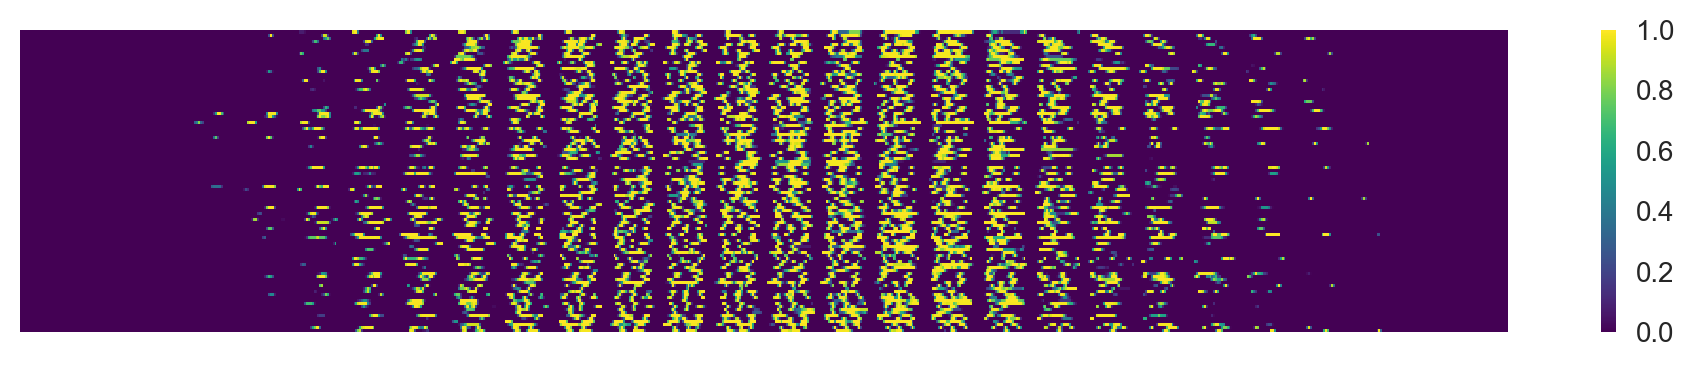

In [66]:
D = read_generic_data("../data/mnist/mnist100.txt")
plot(D)

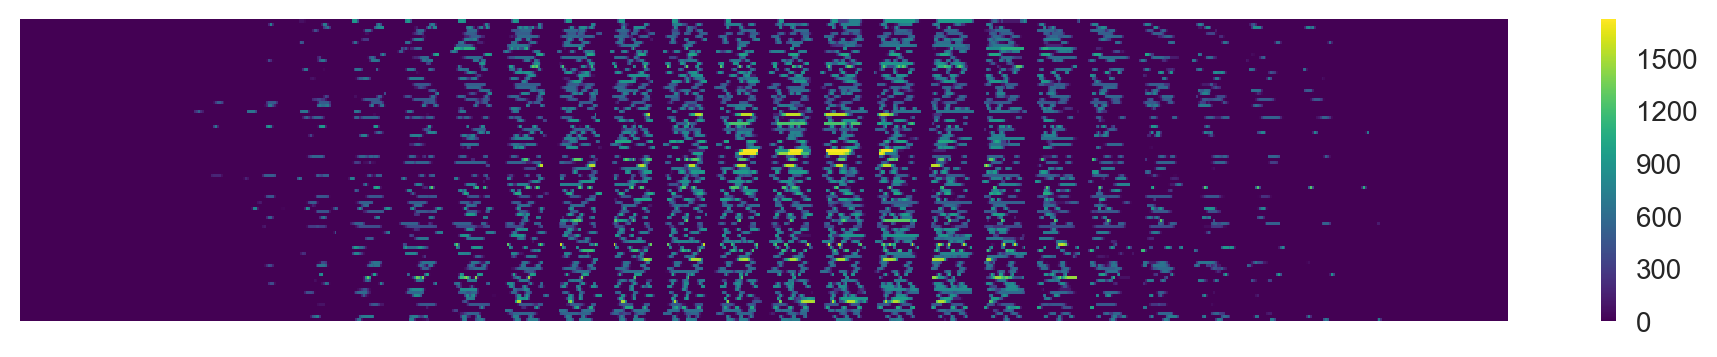

In [67]:
X = standardize_data(D)
plot(X)

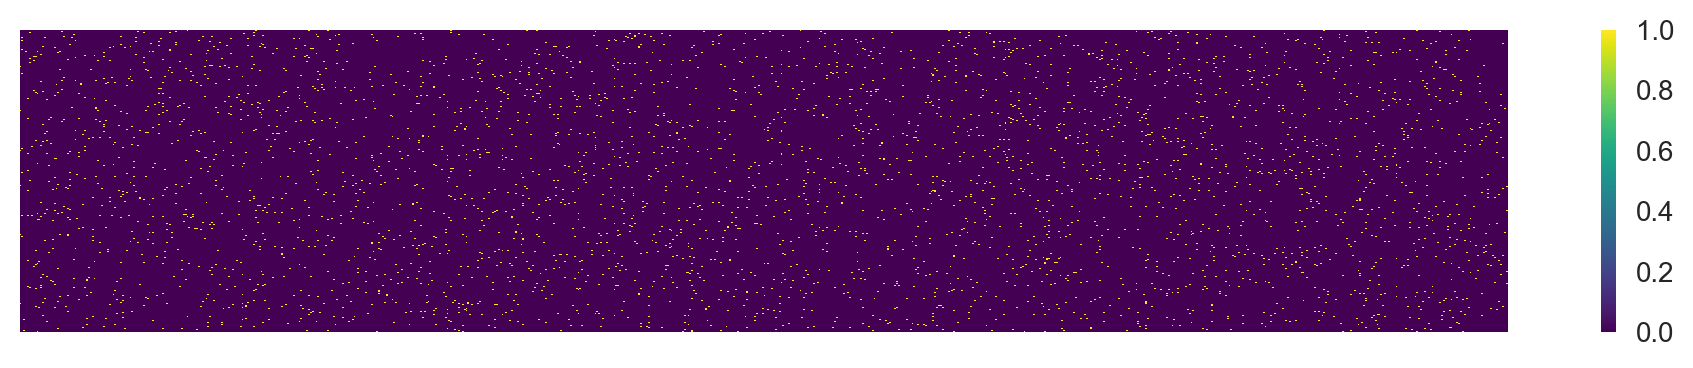

In [68]:
M = create_rand_proj_matrix(SPARSE, SAMPLES)
plot(M)

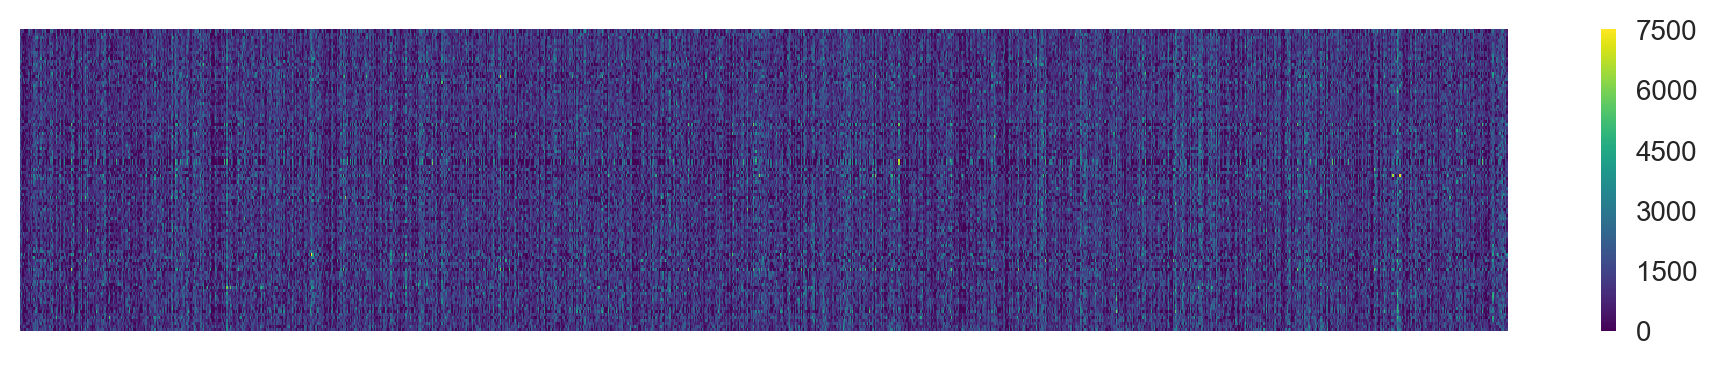

In [69]:
K = np.dot(D,np.transpose(M)) 
plot(K)

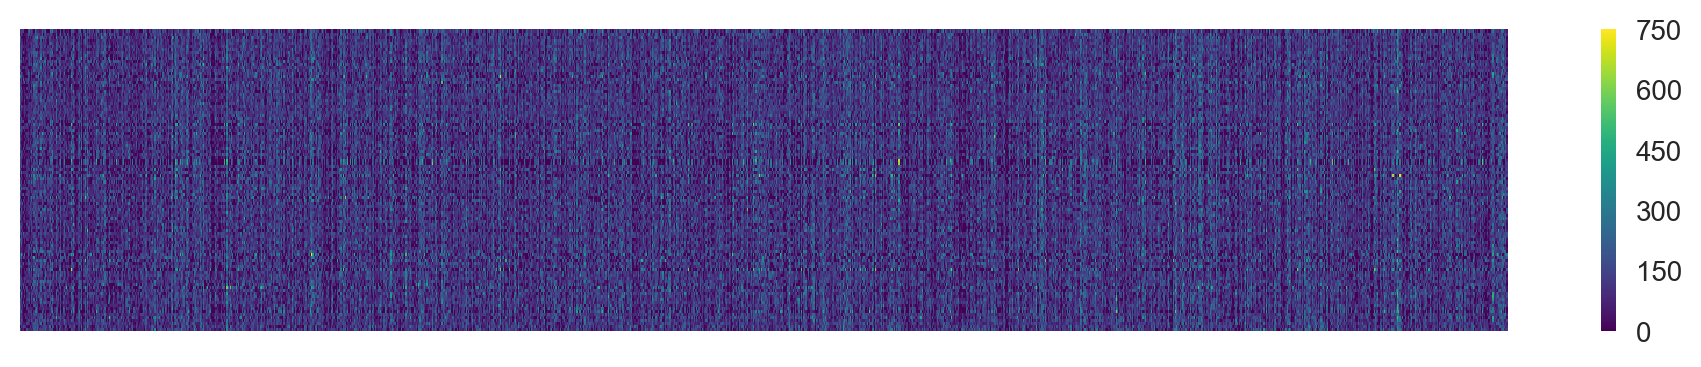

In [70]:
offset,width = 0,10
K = np.floor((K+offset)/width)
plot(K)

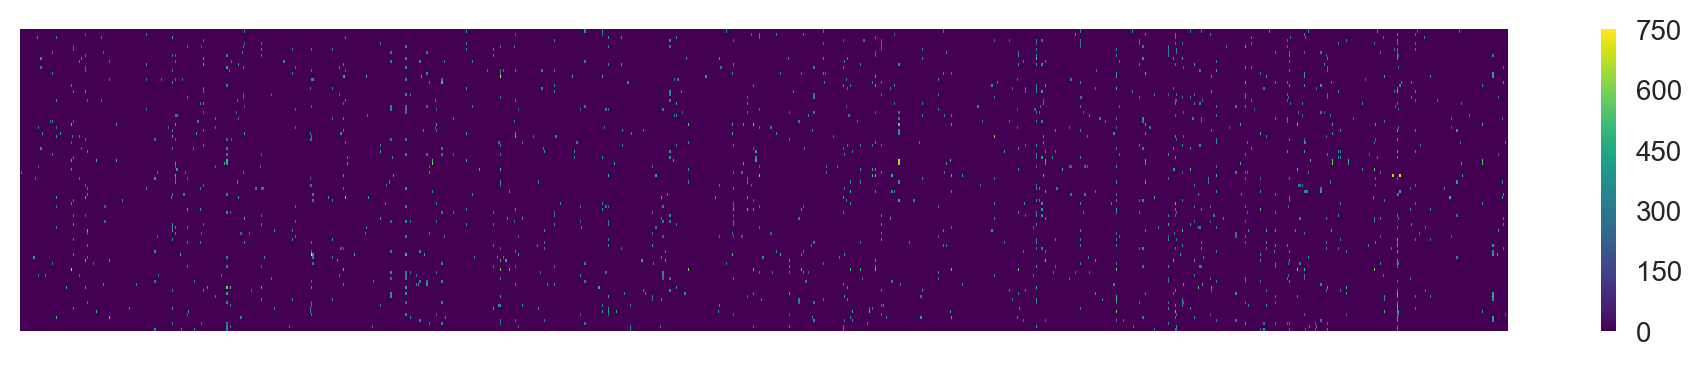

In [71]:
H = winnerTakeAll()
plot(H)

In [72]:
temp_i = []
dij_orig = dist(D[1,:],D[2,:])
temp_i.append( (dij_orig,2) )
temp_i

[(8093.4443224130482, 2)]

In [73]:
tesht_map_dist(D,H)

0.78217685500125977

In [74]:
x_map = [None] * NUM_REPEATS
start = time.time()

for ii in range(NUM_REPEATS):
    x_map[ii] = tesht_map_dist(D,H)

[DIM, SPARSE, SAMPLES, NUM_KENYON, WTA, HASH_LENGTH, np.mean(x_map), np.std(x_map), (time.time()-start) / 60]

[784,
 True,
 12,
 1280,
 'top',
 16,
 0.78217685500125977,
 9.288792252416251e-17,
 0.027462732791900635]